In [1]:
# apply one class SVM to detect '3' duration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

In [3]:
train = pd.read_csv("data/recipe_train_v.csv", header=0)
step = train['steps'].apply(lambda steps: tokenizer.tokenize(steps)).apply(lambda steps: [lemmatizer.lemmatize(word, pos='v') for word in steps])

In [4]:
h = ['hours', 'hour', 'hr', 'h', 'hrs']
print(len([j for i in step for j in i if j in h]))

9102


In [5]:
target = step.apply(lambda x: any(i in h for i in x))
num = target[target].index

In [6]:
hours = step[num].apply(lambda x: [x[i-1:i+1][0] for i in range(len(x)) if x[i] in h]).rename("hours")
print(hours)

4              [1]
5              [4]
15         [8, 24]
19       [4, 2, 1]
21       [several]
           ...    
39969          [1]
39976     [an, an]
39980          [2]
39983        [one]
39985          [2]
Name: hours, Length: 7473, dtype: object


In [7]:
values = sorted(set([j for i in hours for j in i]))
print(values)

['1', '10', '11', '12', '13', '14', '15', '16', '18', '19', '1st', '2', '20', '24', '25', '3', '36', '4', '48', '5', '6', '60', '7', '72', '8', '9', 'a', 'about', 'additional', 'an', 'and', 'another', 'approximately1', 'bake', 'chill', 'couple', 'ea', 'each', 'eight', 'every', 'few', 'final', 'first', 'five', 'for', 'four', 'full', 'further', 'good', 'half', 'hour', 'i', 'l', 'last', 'least', 'least2', 'least4', 'leave', 'make', 'medium', 'more', 'next', 'of', 'on', 'one', 'per', 'pork', 'seven', 'several', 'six', 'smoot', 'the', 'these', 'three', 'top', 'tracy', 'twelve', 'two', 'wit']


In [8]:
s_dict = {"one": 1, "two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9, "ten": 10, "eleven": 11, "twelve": 12,
              "a": 1, "an": 1, "another": 1, "about": 1, "l": 1, "i": 1, "full": 1, "half": 0.5}
def standarize(value):
    if type(value)==int or value.isnumeric():
        return int(value)
    elif any(i.isnumeric() for i in value):
        return int([i for i in value if i.isnumeric()][-1])
    elif value in s_dict.keys():
        return int(s_dict[value])
    else:
        pass


v = [standarize(value) for value in values]
frame = pd.DataFrame([values, v]).transpose()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(frame)
    
# "half an hour"?

                 0     1
0                1     1
1               10    10
2               11    11
3               12    12
4               13    13
5               14    14
6               15    15
7               16    16
8               18    18
9               19    19
10             1st     1
11               2     2
12              20    20
13              24    24
14              25    25
15               3     3
16              36    36
17               4     4
18              48    48
19               5     5
20               6     6
21              60    60
22               7     7
23              72    72
24               8     8
25               9     9
26               a     1
27           about     1
28      additional  None
29              an     1
30             and  None
31         another     1
32  approximately1     1
33            bake  None
34           chill  None
35          couple  None
36              ea  None
37            each  None
38           eight     8


In [9]:
hours = hours.apply(lambda x: sum([standarize(i) for i in x if standarize(i)])).replace(0, np.NaN)

In [10]:
train = pd.merge(train, hours, how='left', left_index=True, right_index=True)

In [24]:
# svm
from sklearn import svm
sample = train.dropna().copy(deep=True)
#.loc[:, ['duration_label', 'hours', 'n_verbs']]

binary = {1: 0, 2: 0, 3: 1}
sample['duration_label'] = sample['duration_label'].apply(lambda x: binary[x])

In [25]:
X = sample.loc[:, ['hours', 'n_verbs', 'n_ingredients']]
y = sample['duration_label']

clf = svm.SVC(kernel='rbf', gamma='auto', C=1)
clf.fit(X, y)
y_hat = clf.predict(X)

In [26]:
# evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

print(accuracy_score(y, y_hat))

precision = precision_score(y, y_hat, average=None, zero_division=0)
recall = recall_score(y, y_hat, average=None, zero_division=0)
f1 = f1_score(y, y_hat, average=None, zero_division=0)

score = pd.DataFrame({'Precision':precision, "Recall":recall, "F_score":f1}, index=['1,2', '3'])
print(score)

matrix = confusion_matrix(y, y_hat)
matrix = pd.DataFrame(matrix, index=['1,2', '3'], columns=['1,2', '3'])
print("\nConfusion matrix:")
print(matrix, end='\n\n')

0.9112845990063875
     Precision    Recall   F_score
1,2   0.931742  0.950714  0.941132
3     0.846108  0.795531  0.820040

Confusion matrix:
      1,2     3
1,2  4996   259
3     366  1424



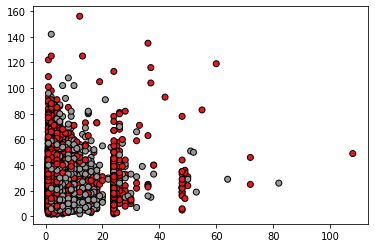

In [29]:
X = sample
plt.scatter(X.loc[:,'hours'], X.loc[:,'n_verbs'], c=X['duration_label'], cmap=plt.cm.Set1, edgecolor='k')